## Netflix Movie Recommendation

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("darkgrid")

In [93]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

## Load Data and Data Preprocessing

In [5]:
movies = pd.read_csv('movie_titles.csv', header = None, usecols = [0,1,2], names = ['MovieID', 'YearOfRelease', 'Title'],encoding='latin1')

In [348]:
movies.head()

,MovieID,YearOfRelease,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [7]:
df1 = pd.read_csv('combined_data_1.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 = pd.read_csv('combined_data_2.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('combined_data_3.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('combined_data_4.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [8]:
df = pd.concat([df1, df2, df3, df4], axis = 0)

In [9]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [10]:
df.shape

(100498277, 2)

In [11]:
df.isnull().sum()

Cust_Id        0
Rating     17770
dtype: int64

In [12]:
# Extract Movie ID:
nan = pd.DataFrame(pd.isnull(df['Rating']))
movie_id = df[nan['Rating'] == True]['Cust_Id']

In [52]:
movie_id.head(401)

0            1:
548          2:
694          3:
2707         4:
2850         5:
           ... 
2104717    397:
2105466    398:
2109032    399:
2109158    400:
2112852    401:
Name: Cust_Id, Length: 401, dtype: object

In [14]:
# Take the ratings for the first 400 movies as our dataset
df_400 = df.iloc[:2112852,]

In [15]:
df_400.shape

(2112852, 2)

In [16]:
movie_id.shape

(17770,)

In [17]:
m_id = movie_id.iloc[:401,]

In [18]:
m_id

0            1:
548          2:
694          3:
2707         4:
2850         5:
           ... 
2104717    397:
2105466    398:
2109032    399:
2109158    400:
2112852    401:
Name: Cust_Id, Length: 401, dtype: object

In [19]:
# Use the index of the movies to generate Movie IDs corresponding to the rows (cutomer IDs)
Movie_ID = []
for i in range(1,401):
    Movie_ID.append((m_id.index[i]-m_id.index[i-1])*[i])
    
MovieID = sum(Movie_ID, [])

In [20]:
# Verify that they are the same length
print(len(MovieID),df_400.shape[0])

2112852 2112852


In [21]:
# Assign the Movie IDs to the rows
df_400['MovieID'] = MovieID

C:\Users\Hanna\MyAnaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_400.head()

,Cust_Id,Rating,MovieID
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1


In [23]:
# Delete the rows with the original Movie IDs
df_400_noNA = df_400.dropna()

In [24]:
df_400_noNA.isnull().sum()

Cust_Id    0
Rating     0
MovieID    0
dtype: int64

In [25]:
df_400_noNA.shape

(2112452, 3)

In [26]:
df_400_noNA.head()

,Cust_Id,Rating,MovieID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


## Create the MovieID column for the whole dataset

In [65]:
# Use the index of the movies to generate Movie IDs corresponding to the rows (cutomer IDs)
Movie_ID = []
for i in range(1,len(movie_id)):
    Movie_ID.append((movie_id.index[i]-movie_id.index[i-1])*[(i)])
    
MovieID = sum(Movie_ID, [])

In [66]:
len(MovieID)
df = df.iloc[:100495019,]
df['MovieID'] = MovieID

100495019

In [72]:
# Remove the rows that used to store the Movies IDs
df_clean = df.dropna()

In [73]:
df_clean.to_csv('C:/Users/Hanna/Desktop/LU/Chapman/2020 Spring/CS 530_Data Mining/Project/df_clean.csv')

In [472]:
df_400_1 = df_clean[df_clean['MovieID']<=400]
df_400_2 = df_clean[(df_clean['MovieID']>400) & (df_clean['MovieID']<=800)]
df_400_3 = df_clean[(df_clean['MovieID']>800) & (df_clean['MovieID']<=1600)]
df_400_1.shape, df_400_2.shape, df_400_3.shape

((2112452, 3), (2116009, 3), (3769760, 3))

In [84]:
def fit_predict(algo, train, test):
    model = algo.fit(train)
    prediction = model.test(test)
    return(accuracy.rmse(prediction))

In [97]:
reader = Reader(rating_scale=(1, 5))
df_all = [df_400_1, df_400_2, df_400_3]
rmse = []

for data in df_all:
    d = Dataset.load_from_df(data[['Cust_Id', 'MovieID', 'Rating']], reader)
    train, test = train_test_split(d, test_size = 0.3)
    
    # SVD:
    svd = SVD(n_factors = 20, lr_all = 0.005, reg_all = 0.01)
    rmse.append(fit_predict(svd, train, test))
    
    # NMF:
    nmf = NMF(n_factors = 20, n_epochs = 20, biased = True)
    rmse.append(fit_predict(nmf, train, test))
    
    # SlopeOne:
    slope = SlopeOne()
    rmse.append(fit_predict(slope, train, test))
    
    # CoClustering:
    cc = CoClustering(n_cltr_u = 2, n_cltr_i = 2)
    rmse.append(fit_predict(cc, train, test))
    
    # BaselineOnly
    bsl_options = {'method': 'sgd','learning_rate': .00005}
    bsl = BaselineOnly(bsl_options = bsl_options)
    rmse.append(fit_predict(bsl, train, test))
    
    # SVD++
    svdpp = SVDpp(n_factors = 50, lr_all = 0.005, reg_all = 0.02)
    rmse.append(fit_predict(svdpp, train, test))

    # KNNBasic
    sim_options = {'name': 'MSD', 'user_based': False}
    knn_basic = KNNBasic(k=20, sim_options = sim_options, min_k = 5)
    rmse.append(fit_predict(knn_basic, train, test))
    
    # KNNWithMeans
    sim_options = {'name': 'MSD', 'user_based': False, 'shrinkage': 10}
    knn = KNNWithMeans(k=20, sim_options = sim_options, min_k = 8)
    rmse.append(fit_predict(knn, train, test))
    
    # KNNBaseline
    sim_options = {'name': 'MSD', 'user_based': False, 'shrinkage': 10}
    knn_bsl = KNNBaseline(k=20, sim_options = sim_options, min_k = 8)
    rmse.append(fit_predict(knn_bsl, train, test))

RMSE: 1.0145
RMSE: 1.0242
RMSE: 1.0348
RMSE: 1.0667
Estimating biases using sgd...
RMSE: 1.0273
RMSE: 0.9772
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0416
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9945
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9797
RMSE: 1.0042
RMSE: 1.0254
RMSE: 1.0268
RMSE: 1.0564
Estimating biases using sgd...
RMSE: 1.0204
RMSE: 0.9724
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0238
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9872
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9734
RMSE: 0.9638
RMSE: 1.0891
RMSE: 0.9731
RMSE: 1.0062
Estimating biases using sgd...
RMSE: 1.0053
RMSE: 0.9340
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0057
Computing

## Plot the RMSE vs Sample Size by Algorithm

In [459]:
# Load the RMSE results for 700 movie subset and 1000 movie subset
df_700 = pd.read_csv('result_700.csv')
df_1k = pd.read_csv('result_1000.csv')

In [504]:
df_1k

,Algorithm,Slice_1,Slice_2,Slice_3
0,SVD,0.9513,0.9358,0.9434
1,NMF,1.0247,1.0010,1.0068
2,SlopeOne,0.9734,0.9576,0.9615
3,CoClustering,0.9993,0.9855,0.9910
4,BaselineOnly,0.9559,0.9436,0.9442
5,SVD++,0.9408,0.9207,0.9246
6,KNNBasic,0.9955,0.9930,1.0405
7,KNNWithMeans,0.9518,0.9407,0.9408
8,KNNBaseline,0.9388,0.9231,0.9266


In [462]:
# Combine the RMSE results for all three subsets into one column
rmse_700 = [x for x in df_700['Slice_1']] + [x for x in df_700['Slice_2']] + [x for x in df_700['Slice_3']]
rmse_1k = [x for x in df_1k['Slice_1']] + [x for x in df_1k['Slice_2']] + [x for x in df_1k['Slice_3']]
rmse_all = rmse + rmse_700 + rmse_1k

In [108]:
# Make a column for Algorithms
algorithms = ['SVD', 'NMF', 'SlopeOne', 'CoClustering', 'BaselineOnly', 'SVD++', 'KNNBasic', 'KNNWithMeans', 'KNNBaseline']
algorithms_3 = algorithms*9

In [172]:
# Make a column for Sample Sizes
size = ['400 Movies']*27+ ['700 Movies']*27+ ['1000 Moives']*27

In [176]:
# Make a column for slices
Slice = [['Slice_1']*9 +['Slice_2']*9 + ['Slice_3']*9]*3
Slices = sum(Slice, []) # Flatten the list of lists

In [466]:
# Combine the columns for RMSE, Algorithms, Sample Sizes, Slices into a dataframe
df_plot = pd.DataFrame({'RMSE': rmse_all, 'Sample Size': size, 'Slice': Slices, 'Algorithms': algorithms_3})

<Figure size 720x1080 with 0 Axes>

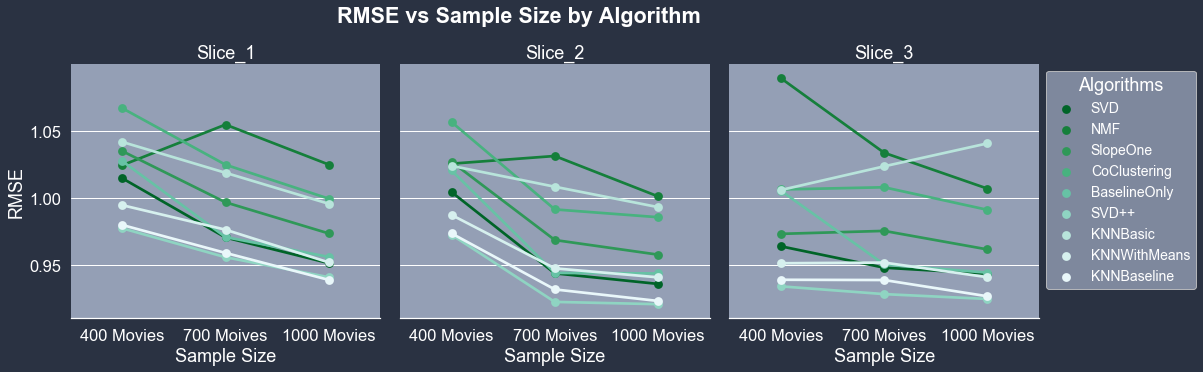

In [503]:
# Plot the RMSE vs Sameple Size for each Slice by Algorithm
plt.figure(figsize=(10,15))

sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242'}, 
        font_scale=1.5)

g=sns.catplot(x="Sample Size", y="RMSE", hue="Algorithms", ci=None, col = 'Slice',
                capsize=.1, kind="point", data=df_plot, legend = False, label='small',palette='BuGn_r')

(g.set_axis_labels("Sample Size", "RMSE")
 .set_xticklabels(['400 Movies', '700 Moives', '1000 Movies'])
 .set_titles("{col_name}")
 .despine(left=True))  

plt.legend(title = 'Algorithms',bbox_to_anchor=(1, 1), fontsize=14)
g.fig.suptitle('RMSE vs Sample Size by Algorithm', y =1.05, fontweight="bold")

plt.show()

## Predictions and Recommendations

In [261]:
# Build the model with the best algorithm (SVD++)
d = Dataset.load_from_df(df_400_3[['Cust_Id', 'MovieID', 'Rating']], reader)
train, test = train_test_split(d, test_size = 0.3)
svdpp = SVDpp(n_factors = 50, lr_all = 0.005, reg_all = 0.02)
svdpp = svdpp.fit(train)

In [439]:
def pred_movie_merge(prediction):
    global movies
    Cust_Id, MovieID, Rating, Predicted_Rating = [], [], [], []
    
    # Convert the predictions to a dataframe:
    for i in range(len(prediction)):
        Cust_Id.append(prediction[i][0])
        MovieID.append(prediction[i][1])
        Predicted_Rating.append(prediction[i][3])
    df = pd.DataFrame({'Cust_Id':Cust_Id,'MovieID':MovieID,'Predicted_Rating':Predicted_Rating}) 
    
    # Merge the predictions and movies datasets to get the Movie Title and Year of Release columns:
    df['MovieID'] = df['MovieID'].astype(str)
    movies['MovieID'] = movies['MovieID'].astype(str)
    pred_movie = pd.merge(df, movies, how = 'left', on = 'MovieID')
    
    return(pred_movie)

In [496]:
def recommend(dataset, model, customerID, top=5):
    m_ids = dataset['MovieID'].unique() # Find unique movie IDs
    rated = dataset.loc[dataset['Cust_Id']==str(customerID),'MovieID'] # Find the movies the customer rated
    m_to_pred = np.setdiff1d(m_ids, rated) # Remove the movies the customer rated
    test_set = [[str(customerID), m, 4.] for m in m_to_pred] # Make a list of the movies to be rated
    prediction = model.test(test_set) # Predict ratings on the movies to be rated   
    pred_movie = pred_movie_merge(prediction) # Get the Title and YearOfRelease columns from the movies dataset
    ratings = pred_movie[pred_movie['Cust_Id']==str(customerID)] # Get the predicted ratings for the specified customerID
    recommendations = ratings.sort_values(['Predicted_Rating'], ascending=0)[['Title','YearOfRelease','Predicted_Rating']][:top]
    print(top,'Movie Recommendations for Customer ' + str(customerID) + ':')
    return(recommendations)

In [453]:
# Recommend 5 movies for customer 1544402
top = 5
recommend(df_400_3, svdpp, 1544402, top)

Movie Recommendations for Customer 1544402:


,Title,YearOfRelease,Predicted_Rating
307,Secondhand Lions,2003.0,5.000000
607,Inu-Yasha: The Movie 3: Swords of an Honorable...,2002.0,5.000000
212,Dr. Quinn,1996.0,5.000000
413,Little House on the Prairie: Season 6,1979.0,4.972555
270,Coach Carter,2005.0,4.933816


In [497]:
# Recommend 7 movies for customer 1488844:
top = 7
recommend(df_400_3, svdpp, 1488844, top)

7 Movie Recommendations for Customer 1488844:


,Title,YearOfRelease,Predicted_Rating
191,I Love Lucy: Season 5,1955.0,4.125647
350,The Andy Griffith Show: Vol 3: Andy Discovers ...,1963.0,4.125529
384,La Femme Nikita: Season 2,1998.0,4.098818
538,Inu-Yasha: The Movie 3: Swords of an Honorable...,2002.0,4.090971
121,Read Or Die,2003.0,4.061142
484,Stargate SG-1: Season 7,2003.0,4.054499
239,As Time Goes By: Series 8,2000.0,4.044096


In [455]:
# Recommend 5 movies for customer 822109:
top = 5
recommend(df_400_3, svdpp, 822109, top = 5)

Movie Recommendations for Customer 822109:


,Title,YearOfRelease,Predicted_Rating
514,Midori Days,2005.0,4.579078
424,Carlos Mencia: Not for the Easily Offended: Li...,2005.0,4.409443
79,Sharpe 4: Sharpe's Enemy,1994.0,4.408602
705,The Twilight Zone: Vol. 42,1962.0,4.340480
437,La Femme Nikita: Season 2,1998.0,4.322515


In [456]:
# Recommend 5 movies for customer 885013:
top = 5
recommend(df_400_3, svdpp, 885013, top = 5)

Movie Recommendations for Customer 885013:


,Title,YearOfRelease,Predicted_Rating
607,Inu-Yasha: The Movie 3: Swords of an Honorable...,2002.0,5.000000
447,Better Off Dead,1985.0,4.858763
69,Seven Samurai,1954.0,4.845166
687,FLCL,2000.0,4.795055
757,Doctor Who: Carnival of Monsters,1973.0,4.768916


In [498]:
# Recommend 5 movies for customer 804974:
top = 5
recommend(df_400_3, svdpp, 804974, top)

5 Movie Recommendations for Customer 804974:


,Title,YearOfRelease,Predicted_Rating
440,The Best of Friends: Vol. 4,1994.0,4.912014
213,The Simpsons: Season 1,1989.0,4.605442
608,The Recruit,2003.0,4.592557
176,Dil Chahta Hai,2001.0,4.555253
264,Coach Carter,2005.0,4.547403


In [492]:
# Predict the rating for user 1488844 on movie 1: 
uid = str(1488844) 
iid = str(1)
pred = svdpp.predict(uid, iid, r_ui=3, verbose=True)
print('The predicted rating for customer %s on moive %s is:'%(uid, iid), round(pred[3],2))

user: 1488844    item: 1          r_ui = 3.00   est = 3.32   {'was_impossible': False}
The predicted rating for customer 1488844 on moive 1 is: 3.32


In [491]:
# Predict the rating for user 822109 on movie 1: 
uid = str(822109) 
iid = str(1)

pred = svdpp.predict(uid, iid, r_ui=5, verbose=True)
print('The predicted rating for customer %s on moive %s is:'%(uid, iid), round(pred[3],2))

user: 822109     item: 1          r_ui = 5.00   est = 3.54   {'was_impossible': False}
The predicted rating for customer 822109 on moive 1 is: 3.54


In [490]:
# Predict the rating for user 885013 on movie 1: 
uid = str(885013)
iid = str(1)

pred = svdpp.predict(uid, iid, r_ui=4, verbose=True)
print('The predicted rating for customer %s on moive %s is:'%(uid, iid), round(pred[3],2))

user: 885013     item: 1          r_ui = 4.00   est = 3.78   {'was_impossible': False}
The predicted rating for customer 885013 on moive 1 is: 3.78
